<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to discuss GP methods with noisy inputs.

<div class="alert alert-info">

**Note:** This material is primarily based on the 2008 paper - [Learning Gaussian Process Models from Uncertain Data](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.156.6130) and, some later discussions from the 2011 paper - [Gaussian Process Training with Input Noise](https://papers.nips.cc/paper/4295-gaussian-process-training-with-input-noise.pdf). 

</div>

In the GP models that we have seen so far, the inputs ($X$) are assumed to be noise free. But what happens if the inputs are corrupted? For instance, consider a simple problem in which the inputs are 1-dimensional and there is a single continuous output. Here we will assume that the output ($y$) is corrupted by an input-independent observation noise (homoscedastic).


### Model
Let ${\bf x}$ and $y$ denote the inputs and target for the regression problem, such that ${\bf x} \in \mathbb{R}^D$. The relationship between ${\bf x}$ and $y$ is the same as the GPR models we have seen so far, i.e.,
$$
y = f({\bf x}) + \epsilon
$$
where $f \sim \mathcal{GP}(m({\bf x}),k({\bf x},{\bf x}'))$ and $\epsilon \in \mathcal{N}(0,\sigma_n^2)$. 

Of course, for this setup, we can get closed-form expressions for the predictive mean and variance at a new test instance, ${\bf x}_*$.

### Introducing input noise
In the noisy input world, we assume that each data instance, ${\bf x}_i$ is a random variable distributed as: ${\bf x}_i \sim \mathcal{N}(\boldsymbol{\mu}_i,\Sigma_i)$.
> Note: Each noisy input has its own unique mean and variance

In this case, the covariance between any two instances, ${\bf x}_i$ and ${\bf x}_j$ is given as: 
$$
k({\bf x}_i,{\bf x}_j) = \int\int k({\bf x}'_i,{\bf x}'_j)p({\bf x}'_i\vert \boldsymbol{\mu}_i,\Sigma_i),p({\bf x}'_j\vert \boldsymbol{\mu}_j,\Sigma_j)d{\bf x}'_i d{\bf x}'_j
$$
For certain covariance functions, the above double integral can be analytically computed, given that both $p({\bf x}_i\vert \boldsymbol{\mu}_i,\Sigma_i)$ and $p({\bf x}_j\vert \boldsymbol{\mu}_j,\Sigma_j)$ are Gaussians. For example, if $k(\cdot,\cdot)$ is the _squared exponential_ covariance function, with lengthscale $l$, then the above covariance function can be written as:
$$
k({\bf x}_i,{\bf x}_j) = \frac{\sigma_f^2\exp{((\boldsymbol{\mu}_i-\boldsymbol{\mu}_j)^\top(lI + \Sigma_i + \Sigma_j)^{-1}(\boldsymbol{\mu}_i-\boldsymbol{\mu}_j))}}{\vert I + \frac{1}{l}(\Sigma_i + \Sigma_j)\vert^{\frac{1}{2}}}
$$
This is also a squared exponential function. Which essentially means that we can now learn the model hyperparameters by maximizing the marginal log-likelihood of the data, and get the predictive mean and variance at a new location, ${\bf x}_*$. 
> Note: While, theoretically, the hyperparameter estimation step is same as that for classical GPR, the marginal log-likelihood in this case typically has many local maxima which makes the optimization process challenging. It is typically suggested to put a prior on the hyper-parameters to deal with that issue.

Of course, if the test input also comes with an uncertainty, i.e., ${\bf x}_* \sim \mathcal{N}(\boldsymbol{\mu}_*,\Sigma_*)$, then one will have to estimate the predictive distribution as:
$$
p(y_*\vert {\bf x}_*) = \int p(y_*\vert {\bf x}_*')p({\bf x}_*)d{\bf x}_*
$$
> The integration is generally challenging since ${\bf x}_*$ is an integral. However, one can use a *Monte Carlo* approximation:
$$
p(y_*\vert {\bf x}_*) = \frac{1}{n}\sum_{{\bf x}_i \sim \mathcal{N}(\boldsymbol{\mu}_*,\Sigma_*)} p(y_*\vert {\bf x}_*')p({\bf x}_*')d{\bf x}_*'
$$

In [30]:
%run Utilities.ipynb

In [49]:
# sample inputs and outputs
X = np.random.uniform(-3., 3., (20, 1))
Y = np.sin(X) + np.random.randn(20, 1) * 0.05
Z = np.random.uniform(-3., 3., (7, 1)) #inducing points

In [75]:
S = np.empty((20, 1))
mdpt = np.percentile(X,90)
S[X < mdpt] = 0.001
S[X >= mdpt] = 1


Name : GP regression
Objective : -13.369334861525417
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     1.4619948423331492  |      +ve      |        
  rbf.lengthscale          |      1.924814951241263  |      +ve      |        
  Gaussian_noise.variance  |  0.0028942189057384925  |      +ve      |        



Name : sparse_gp
Objective : 1.3084088295222216
Number of Parameters : 23
Number of Optimization Parameters : 23
Updates : True
Parameters:
  sparse_gp.               |                 value  |  constraints  |  priors
  inducing_inputs          |               (20, 1)  |               |        
  rbf.variance             |     0.539366856281384  |      +ve      |        
  rbf.lengthscale          |    1.5817299539573524  |      +ve      |        
  Gaussian_noise.variance  |  0.024427796361205623  |      +ve      |        


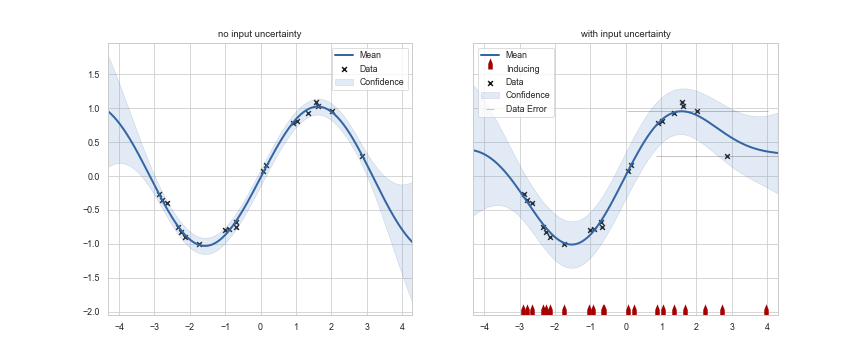

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
max_iters=200
optimize=True
plot=True


k = GPy.kern.RBF(1)
# create simple GP Model - no input uncertainty on this one
#m1 = GPy.models.SparseGPRegression(X, Y, kernel=k, Z=Z)
#m1 = GPy.models.SparseGPRegression(X, Y, kernel=k, num_inducing=X.shape[0])
m1 = GPy.models.GPRegression(X, Y, kernel=k)
m1.optimize('scg', messages=1, max_iters=max_iters)
m1.plot(ax=axes[0])
axes[0].set_title('no input uncertainty')
print(m1)

# the same Model with uncertainty
m2 = GPy.models.SparseGPRegression(X, Y, kernel=GPy.kern.RBF(1), num_inducing=X.shape[0], X_variance=S)
m2.optimize('scg', messages=1, max_iters=max_iters)
m2.plot(ax=axes[1])
axes[1].set_title('with input uncertainty')
fig.canvas.draw()

print(m2)